In [ ]:
# from google.colab import auth
# auth.authenticate_user()

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
import warnings
 
warnings.filterwarnings("ignore")
plt.rc('font', family='NanumBarunGothic') 

%matplotlib inline

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
scr =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/CARD_SPENDING_RESIDENT.txt', sep='\t')
dong = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/전체동별클러스터링.csv', sep = ',', encoding='UTF-8')
dong_cd = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/SC동코드변환.csv', sep = ',',encoding='UTF-8')
SCR = scr

In [ ]:
#카테고리 이름 바꾸기(구, 업종별) ...자동화 하고싶다고요 했고요!!!
# 코드 -> 이름으로 바꾸는 함수 : name_a_to_b
# scr = SCR
def name_a_to_b(data,col,a,b):
  data = data.replace({col:a}, {col:b}, inplace=True)
  return(data)

# 카테고리 코드 -> 이름
cat_code = [10,20,21,22,30,31,32,33,34,35,40,42,43,44,50,52,60,62,70,71,80,81,92]
cat_name = ['숙박','레저용품','레저업소','문화취미','가구','전기','주방용구',
            '연료판매','광학제품','가전','유통업','의복','직물','신변잡화','서적문구','사무통신',
            '자동차판매','자동차정비','의료기관','보건위생','요식업소','음료식품','수리서비스']
for i in range(len(cat_code)):
  name_a_to_b(scr,'MCT_CAT_CD',cat_code[i],cat_name[i])

# # 시구 및 동 이름 추가
scr = pd.merge(scr, dong_cd, left_on=['GU_CD', 'DONG_CD'], right_on=['GU_CD', 'HDONG_CD'])
scr = scr.drop(['GU_CD', 'DONG_CD'], axis=1)
# 날짜 형식으로 변환(int->str->date)
scr.STD_DD = pd.to_datetime(scr['STD_DD'].astype(str), format='%Y%m%d',infer_datetime_format=True)
scr['AGE_CD'] = scr['AGE_CD'].astype('category')
scr['HDONG_CD'] = scr['HDONG_CD'].astype('category')
# 서울만
scr = scr.query("GU_NM in ['서울 중구', '서울 노원구']")
SCR = scr
# # 클러스터링 추가
# scr = pd.merge(scr, dong, left_on='HDONG_NM', right_on='HDONG_NM')

# **1. 전체 카테고리별 매출 분석**

##카테고리별 매출 순위 (2019,2020)

In [ ]:
scr_a = scr.groupby(['STD_DD','MCT_CAT_CD']).sum()
scr19 = scr.reset_index().query("'2019-02-01' <= STD_DD <= '2019-05-31'").groupby(['MCT_CAT_CD']).sum().sort_values(by='USE_AMT',ascending=False)
scr20 = scr.reset_index().query("'2020-02-01' <= STD_DD <= '2020-05-31'").groupby(['MCT_CAT_CD']).sum().sort_values(by='USE_AMT',ascending=False)

In [ ]:
print("<<연도별 이용금액 순위>>")
print(list(scr19.index))
print(list(scr20.index))
print("\n<<연도별 이용건수 순위>>")
print(list(scr19.sort_values(by='USE_CNT',ascending=False).index))
print(list(scr20.sort_values(by='USE_AMT',ascending=False).index))

<<연도별 이용금액 순위>>
['유통업', '요식업소', '의료기관', '레저용품', '보건위생', '의복', '숙박', '연료판매', '음료식품', '레저업소', '사무통신', '가전', '서적문구', '자동차정비', '신변잡화', '문화취미', '주방용구', '광학제품', '직물', '수리서비스', '가구', '자동차판매', '전기']
['유통업', '요식업소', '의료기관', '레저용품', '보건위생', '음료식품', '연료판매', '의복', '숙박', '레저업소', '사무통신', '가전', '서적문구', '자동차정비', '신변잡화', '문화취미', '주방용구', '가구', '수리서비스', '직물', '광학제품', '자동차판매', '전기']

<<연도별 이용건수 순위>>
['요식업소', '유통업', '의료기관', '음료식품', '사무통신', '레저업소', '보건위생', '자동차정비', '연료판매', '서적문구', '레저용품', '의복', '문화취미', '숙박', '신변잡화', '수리서비스', '가전', '광학제품', '주방용구', '직물', '가구', '자동차판매', '전기']
['유통업', '요식업소', '의료기관', '레저용품', '보건위생', '음료식품', '연료판매', '의복', '숙박', '레저업소', '사무통신', '가전', '서적문구', '자동차정비', '신변잡화', '문화취미', '주방용구', '가구', '수리서비스', '직물', '광학제품', '자동차판매', '전기']


In [ ]:
# 요식업소, 유통업 비중
scr.groupby(['MCT_CAT_CD']).sum().loc[:,'USE_CNT'][['유통업','요식업소']].sum()/scr.groupby(['MCT_CAT_CD']).sum().loc[:,'USE_CNT'].sum()
scr.groupby(['MCT_CAT_CD']).sum().loc[:,'USE_AMT'][['유통업','요식업소']].sum()/scr.groupby(['MCT_CAT_CD']).sum().loc[:,'USE_AMT'].sum()

0.6325337787768428

In [ ]:
cat_dict_amt = scr19.reset_index().MCT_CAT_CD.to_dict()
scr19['CAT_CD_AMT']=range(len(scr19)) ; scr20['CAT_CD_AMT']=0
cat_dict_amt = {v:k for k,v in cat_dict_amt.items()} 
for k,v in cat_dict_amt.items():
  scr20.loc[k].loc['CAT_CD_AMT'] = v

In [ ]:
# 증감률
# 설날 2019 2월 4,5,6일 보정
scr_g = scr.groupby(['STD_DD','MCT_CAT_CD']).sum().fillna(0).unstack()
for i in ['USE_CNT','USE_AMT']:
  scr_g.xs(i,axis=1,level=0).loc['2019-02-04'] = (scr_g.xs(i,axis=1,level=0).loc['2019-02-11']+scr_g.xs(i,axis=1,level=0).loc['2019-02-18'])/2
  scr_g.xs(i,axis=1,level=0).loc['2019-02-05'] = (scr_g.xs(i,axis=1,level=0).loc['2019-02-12']+scr_g.xs(i,axis=1,level=0).loc['2019-02-19'])/2
  scr_g.xs(i,axis=1,level=0).loc['2019-02-06'] = (scr_g.xs(i,axis=1,level=0).loc['2019-02-13']+scr_g.xs(i,axis=1,level=0).loc['2019-02-20'])/2
  
scr_g = scr_g.reset_index(drop=False)
scr_g = scr_g[scr_g.STD_DD != '2019-02-01'] ; scr_g = scr_g[scr_g.STD_DD != '2020-05-30'] ; scr_g = scr_g[scr_g.STD_DD != '2020-05-31'] 
scr_g = scr_g.set_index('STD_DD').stack()

scr_gr19 = scr_g.unstack().loc['2019-02-01':'2019-05-31',:]
scr_gr20 = scr_g.unstack().loc['2020-02-01':'2020-05-31',:]

scr_gr = pd.DataFrame((scr_gr20.sum() - scr_gr19.sum())/scr_gr19.sum()*100).rename(columns ={0:'증감률'}).T
scr_gr

USE_AMT                        ...    USE_CNT                     
MCT_CAT_CD         가구         가전       광학제품  ...         전기      주방용구         직물
증감률         12.549672 -26.959874 -27.195941  ...  29.235936  2.295583 -11.796914

[1 rows x 46 columns]

In [ ]:
scr_gr.xs('USE_AMT',axis=1,level=0)
scr_gr.xs('USE_CNT',axis=1,level=0)

MCT_CAT_CD,가구,가전,광학제품,레저업소,레저용품,문화취미,보건위생,사무통신,서적문구,수리서비스,숙박,신변잡화,연료판매,요식업소,유통업,음료식품,의료기관,의복,자동차정비,자동차판매,전기,주방용구,직물
증감률,-15.776576,-29.337882,-21.506279,-10.294587,-22.574793,-36.967002,-34.726269,-32.949334,-40.511824,-6.87661,-27.166559,-40.923392,-21.937286,-12.110812,-17.71859,-6.573748,3.088988,-47.509017,-40.307872,11.581757,29.235936,2.295583,-11.796914


In [ ]:
scr_gr.xs('USE_AMT',axis=1,level=0)[['유통업', '요식업소', '의료기관', '레저용품', '보건위생', '의복', '숙박', '연료판매', '음료식품', '레저업소']].values.mean()
scr_gr.xs('USE_CNT',axis=1,level=0)[['유통업', '요식업소', '의료기관', '레저용품', '보건위생', '의복', '숙박', '연료판매', '음료식품', '레저업소']].values.mean()

-19.752267200463354

## 카테고리별 이용금액, 이용건수 그래프

Index(['요식업소', '유통업', '의료기관', '음료식품', '사무통신', '레저업소', '보건위생', '자동차정비', '연료판매',
       '서적문구'],
      dtype='object', name='MCT_CAT_CD')
Index(['요식업소', '유통업', '의료기관', '음료식품', '사무통신', '레저업소', '보건위생', '연료판매', '레저용품',
       '자동차정비'],
      dtype='object', name='MCT_CAT_CD')


[Text(0, 0, '요식업소'), Text(0, 0, '유통업'), Text(0, 0, '의료기관')]

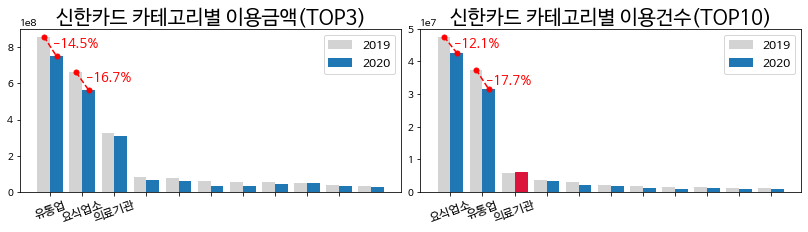

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 3))
plt.subplots_adjust(wspace = 0.05) # hspace = 0.2

dat_a19=scr19[:11]
dat_a20=scr20[:11]
ax1.bar(dat_a19.CAT_CD_AMT-0.2, dat_a19.USE_AMT, width=0.4, color = 'lightgrey', label="2019")
ax1.bar(dat_a20.CAT_CD_AMT+0.2, dat_a20.USE_AMT, width=0.4, label="2020")
ax1.set_title('신한카드 카테고리별 이용금액(TOP3)', fontsize=20)
ax1.legend(prop={'size': 12})
for i in range(2):
  ax1.plot([i-0.2,i+0.2],(dat_a19.USE_AMT[i],dat_a20.USE_AMT[i]),marker='o',color='r',linestyle='--',markersize=5)
  ax1.text(x=i+0.1,y=dat_a20.USE_AMT[i]+50000000,s=(str(round(scr_gr.xs('USE_AMT',axis=1,level=0)[['유통업','요식업소']].iloc[0,i],1))+'%'),color='r',fontsize=13)
ax1.set_xticks(np.array(range(10)))
ax1.set_xticklabels(dat_a19.CAT_CD_AMT.index.to_list()[:3],fontsize=12,rotation=20)


print(scr19.sort_values(by='USE_CNT',ascending=False)[:10].index)
print(scr20.sort_values(by='USE_CNT',ascending=False)[:10].index)
scr_cnt_dict = {'요식업소':0, '유통업':1, '의료기관':2, '음료식품':3, '사무통신':4, '레저업소':5, '보건위생':6, '자동차정비':7, '연료판매':8,
                '서적문구':9,'레저용품':10}
dat_c19 = scr19.loc[list(scr_cnt_dict.keys()),:]
dat_c20 = scr20.loc[list(scr_cnt_dict.keys()),:]
dat_c19['CAT_CD_CNT'] = range(len(dat_c19))
dat_c20['CAT_CD_CNT'] = range(len(dat_c20))
ax2.bar(dat_c19.CAT_CD_CNT-0.2, dat_c19.USE_CNT, width=0.4, color = 'lightgrey', label="2019")
ax2.bar(dat_c20.CAT_CD_CNT+0.2, dat_c20.USE_CNT, width=0.4, label="2020")[2].set_color('crimson')
for i in range(2):
  ax2.plot([i-0.2,i+0.2],(dat_c19.USE_CNT[i],dat_c20.USE_CNT[i]),marker='o',color='r',linestyle='--',markersize=5)
  ax2.text(x=i+0.1,y=dat_c20.USE_CNT[i]+1500000,s=(str(round(scr_gr.xs('USE_CNT',axis=1,level=0)[['요식업소','유통업']].iloc[0,i],1))+'%'),color='r',fontsize=13)

ax2.set_title('신한카드 카테고리별 이용건수(TOP10)', fontsize=20)
ax2.legend(prop={'size': 12})
ax2.set_xticks(np.array(range(11)))
ax2.set_xticklabels(list(scr_cnt_dict.keys())[:3],fontsize=12,rotation=20)

## 카테고리별 이용금액, 이용건수 그래프 (TOP3)

[Text(0, 0, '요식업소'), Text(0, 0, '유통업'), Text(0, 0, '의료기관')]

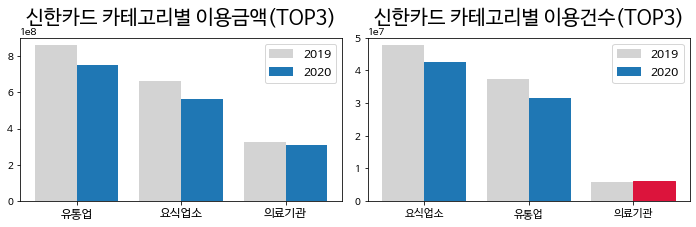

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 3))
plt.subplots_adjust(wspace = 0.08, hspace = 1) # hspace = 0.2

ax1.bar(dat_a19[:3].CAT_CD_AMT-0.2, dat_a19[:3].USE_AMT, width=0.4, color = 'lightgrey', label="2019")
ax1.bar(dat_a20[:3].CAT_CD_AMT+0.2, dat_a20[:3].USE_AMT, width=0.4, label="2020")
ax1.set_title('신한카드 카테고리별 이용금액(TOP3)', fontsize=20,pad=15)
ax1.legend(prop={'size': 12})
ax1.set_xticks(np.array(range(3)))
ax1.set_xticklabels(dat_a19[:3].CAT_CD_AMT.index.to_list(),fontsize=12)

ax2.bar(dat_c19[:3].CAT_CD_CNT-0.2, dat_c19[:3].USE_CNT, width=0.4, color = 'lightgrey', label="2019")
ax2.bar(dat_c20[:3].CAT_CD_CNT+0.2, dat_c20[:3].USE_CNT, width=0.4, label="2020")[2].set_color('crimson')
ax2.set_title('신한카드 카테고리별 이용건수(TOP3)', fontsize=20,pad=15)
ax2.legend(prop={'size': 12})
ax2.set_xticks(np.array(range(3)))
ax2.set_xticklabels(list(scr_cnt_dict.keys()),fontsize=11)

## 카테고리별 이용금액, 이용건수 그래프 (나머지)

[Text(0, 0, '음료식품'),
 Text(0, 0, '사무통신'),
 Text(0, 0, '레저업소'),
 Text(0, 0, '보건위생'),
 Text(0, 0, '자동차정비'),
 Text(0, 0, '연료판매'),
 Text(0, 0, '서적문구'),
 Text(0, 0, '레저용품')]

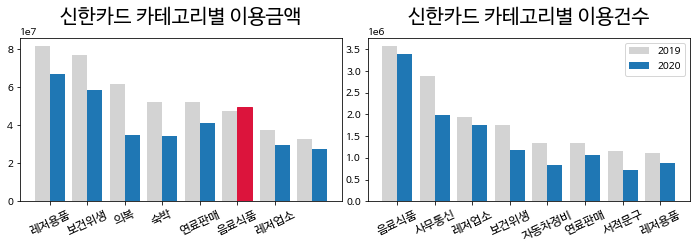

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 3))
plt.subplots_adjust(wspace = 0.08, hspace = 0.2) # hspace = 0.2

ax1.bar(dat_a19[3:].CAT_CD_AMT-0.2, dat_a19[3:].USE_AMT, width=0.4, color = 'lightgrey', label="2019")
ax1.bar(dat_a20[3:].CAT_CD_AMT+0.2, dat_a20[3:].USE_AMT, width=0.4, label="2020")[2].set_color('crimson')
ax1.set_title('신한카드 카테고리별 이용금액', fontsize=20,pad=15)
ax1.set_xticks(np.array(range(7))+3)
ax1.set_xticklabels(dat_a19[3:].CAT_CD_AMT.index.to_list(),fontsize=12, rotation=25)

ax2.bar(dat_c19[3:].CAT_CD_CNT-0.2, dat_c19[3:].USE_CNT, width=0.4, color = 'lightgrey', label="2019")
ax2.bar(dat_c20[3:].CAT_CD_CNT+0.2, dat_c20[3:].USE_CNT, width=0.4, label="2020")
ax2.set_title('신한카드 카테고리별 이용건수', fontsize=20,pad=15)
ax2.legend(prop={'size': 10})
ax2.set_xticks(np.array(range(8))+3)
ax2.set_xticklabels(list(scr_cnt_dict.keys())[3:],fontsize=12, rotation=25)

## 카테고리별 매출 증감률 순위

In [ ]:
# 설날 2019 2월 4,5,6일 보정
scr_g = scr.groupby(['STD_DD','MCT_CAT_CD']).sum().fillna(0).unstack()
for i in ['USE_CNT','USE_AMT']:
  scr_g.xs(i,axis=1,level=0).loc['2019-02-04'] = (scr_g.xs(i,axis=1,level=0).loc['2019-02-11']+scr_g.xs(i,axis=1,level=0).loc['2019-02-18'])/2
  scr_g.xs(i,axis=1,level=0).loc['2019-02-05'] = (scr_g.xs(i,axis=1,level=0).loc['2019-02-12']+scr_g.xs(i,axis=1,level=0).loc['2019-02-19'])/2
  scr_g.xs(i,axis=1,level=0).loc['2019-02-06'] = (scr_g.xs(i,axis=1,level=0).loc['2019-02-13']+scr_g.xs(i,axis=1,level=0).loc['2019-02-20'])/2
  
scr_g = scr_g.reset_index(drop=False)
scr_g = scr_g[scr_g.STD_DD != '2019-02-01'] ; scr_g = scr_g[scr_g.STD_DD != '2020-05-30'] ; scr_g = scr_g[scr_g.STD_DD != '2020-05-31'] 
scr_g = scr_g.set_index('STD_DD').stack()

scr_gr19 = scr_g.unstack().loc['2019-02-01':'2019-05-31',:]
scr_gr20 = scr_g.unstack().loc['2020-02-01':'2020-05-31',:]

scr_gr = pd.DataFrame((scr_gr20.sum() - scr_gr19.sum())/scr_gr19.sum()*100).rename(columns ={0:'증감률'}).T
scr_gr

USE_AMT                        ...    USE_CNT                     
MCT_CAT_CD         가구         가전       광학제품  ...         전기      주방용구         직물
증감률         12.549672 -26.959874 -27.195941  ...  29.235936  2.295583 -11.796914

[1 rows x 46 columns]

Text(0.5, 1.0, '신한카드 카테고리별 이용건수 증감률(%)')

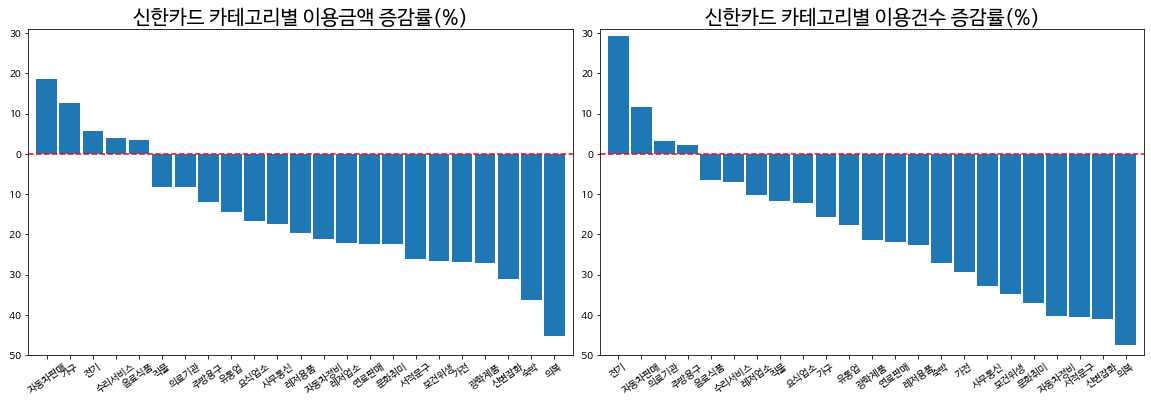

In [ ]:
# 전체 데이터 주차별 성장률 그래프

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
plt.subplots_adjust(wspace = 0.05) # hspace = 0.2

ax1.bar(scr_gr.xs('USE_AMT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,scr_gr.xs('USE_AMT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).증감률, width=0.9)
ax1.set_xlim(-0.8,22.8)
ax1.set_ylim(-50,31)
ax1.set_xticklabels(scr_gr.xs('USE_AMT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,rotation=35)
ax1.set_title('신한카드 카테고리별 이용금액 증감률(%)', fontsize=20)
ax1.axhline(y=0, color='r',linestyle='--')

ax2.bar(scr_gr.xs('USE_CNT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,scr_gr.xs('USE_CNT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).증감률, width=0.9)
ax2.set_xlim(-0.8,22.8)
ax2.set_ylim(-50,31)
ax2.set_xticklabels(scr_gr.xs('USE_CNT',axis=1,level=0).T.sort_values(by='증감률',ascending=False).index,rotation=35)
ax2.axhline(y=0, color='r',linestyle='--')
ax2.set_title('신한카드 카테고리별 이용건수 증감률(%)', fontsize=20)



# **2. 카테고리별 매출 순위**

In [ ]:
# # 클러스터링 추가
scr_c = pd.merge(SCR, dong, left_on='HDONG_NM', right_on='HDONG_NM').groupby(['STD_DD','CLUS_NM','MCT_CAT_CD']).sum()
scr_c19 = scr_c.reset_index().query("'2019-02-01' <= STD_DD <= '2019-05-31'").groupby(['CLUS_NM','MCT_CAT_CD']).sum()
scr_c20 = scr_c.reset_index().query("'2020-02-01' <= STD_DD <= '2020-05-31'").groupby(['CLUS_NM','MCT_CAT_CD']).sum()

clus_list = ['노원구 대학가','노원구 학원가','중구 빌딩숲','중구 소상공']
for i in clus_list:
  print(i)
  print("<<연도별 이용금액 순위>>")
  print('19년:',list(scr_c19.loc[i].sort_values(by='USE_AMT',ascending=False).index))
  print('20년:',list(scr_c20.loc[i].sort_values(by='USE_AMT',ascending=False).index))
  print("<<연도별 이용건수 순위>>")
  print('19년:',list(scr_c19.loc[i].sort_values(by='USE_CNT',ascending=False).index))
  print('20년:',list(scr_c20.loc[i].sort_values(by='USE_CNT',ascending=False).index))

노원구 대학가
<<연도별 이용금액 순위>>
19년: ['의료기관', '요식업소', '유통업', '연료판매', '보건위생', '레저업소', '음료식품', '가전', '자동차정비', '레저용품', '서적문구', '의복', '숙박', '수리서비스', '주방용구', '문화취미', '신변잡화', '광학제품', '사무통신', '전기', '자동차판매', '직물', '가구']
20년: ['의료기관', '요식업소', '유통업', '연료판매', '음료식품', '보건위생', '레저업소', '가전', '자동차정비', '레저용품', '서적문구', '의복', '문화취미', '숙박', '수리서비스', '주방용구', '신변잡화', '사무통신', '직물', '자동차판매', '전기', '가구', '광학제품']
<<연도별 이용건수 순위>>
19년: ['유통업', '요식업소', '의료기관', '연료판매', '음료식품', '레저업소', '보건위생', '서적문구', '레저용품', '자동차정비', '의복', '문화취미', '숙박', '수리서비스', '가전', '신변잡화', '사무통신', '광학제품', '주방용구', '직물', '전기', '자동차판매', '가구']
20년: ['유통업', '요식업소', '의료기관', '음료식품', '연료판매', '레저업소', '보건위생', '서적문구', '레저용품', '문화취미', '수리서비스', '자동차정비', '숙박', '의복', '가전', '신변잡화', '주방용구', '사무통신', '광학제품', '직물', '전기', '자동차판매', '가구']
노원구 학원가
<<연도별 이용금액 순위>>
19년: ['유통업', '요식업소', '의료기관', '보건위생', '음료식품', '연료판매', '레저업소', '의복', '서적문구', '자동차정비', '가전', '문화취미', '레저용품', '신변잡화', '수리서비스', '가구', '광학제품', '직물', '숙박', '주방용구', '사무통신', '전기', '자동차판매']
20년: ['유통업', '요식업소', '의료기관', '음료식품',

In [ ]:
scr_c_g = scr_c.unstack().fillna(0)
for i in ['USE_CNT','USE_AMT']:
  scr_c_g.xs(i,axis=1,level=0).loc['2019-02-04'] = (scr_c_g.xs(i,axis=1,level=0).loc['2019-02-11'].values + scr_c_g.xs(i,axis=1,level=0).loc['2019-02-18'].values)/2
  scr_c_g.xs(i,axis=1,level=0).loc['2019-02-05'] = (scr_c_g.xs(i,axis=1,level=0).loc['2019-02-12'].values + scr_c_g.xs(i,axis=1,level=0).loc['2019-02-19'].values)/2
  scr_c_g.xs(i,axis=1,level=0).loc['2019-02-06'] = (scr_c_g.xs(i,axis=1,level=0).loc['2019-02-13'].values + scr_c_g.xs(i,axis=1,level=0).loc['2019-02-20'].values)/2


In [ ]:
scr_c_g = scr_c.unstack().fillna(0)
for i in ['USE_CNT','USE_AMT']:
  scr_c_g.xs(i,axis=1,level=0).loc['2019-02-04'] = (scr_c_g.xs(i,axis=1,level=0).loc['2019-02-11'].values + scr_c_g.xs(i,axis=1,level=0).loc['2019-02-18'].values)/2
  scr_c_g.xs(i,axis=1,level=0).loc['2019-02-05'] = (scr_c_g.xs(i,axis=1,level=0).loc['2019-02-12'].values + scr_c_g.xs(i,axis=1,level=0).loc['2019-02-19'].values)/2
  scr_c_g.xs(i,axis=1,level=0).loc['2019-02-06'] = (scr_c_g.xs(i,axis=1,level=0).loc['2019-02-13'].values + scr_c_g.xs(i,axis=1,level=0).loc['2019-02-20'].values)/2

scr_c_g = scr_c_g.reset_index()
scr_c_g = scr_c_g[scr_c_g.STD_DD != '2019-02-01'] ;scr_c_g = scr_c_g[scr_c_g.STD_DD != '2020-05-30'] ;scr_c_g = scr_c_g[scr_c_g.STD_DD != '2020-05-31'] 
scr_c_g = scr_c_g.set_index(['STD_DD','CLUS_NM']).stack()
#증감률 계산
scr_c_gr19 = scr_c_g.loc[:'2019-05-31',:]
scr_c_gr20 = scr_c_g.loc['2020-02-01':'2020-05-29',:]

scr_c_gr = (scr_c_gr20.groupby(['CLUS_NM','MCT_CAT_CD']).sum() - scr_c_gr19.groupby(['CLUS_NM','MCT_CAT_CD']).sum())/scr_c_gr19.groupby(['CLUS_NM','MCT_CAT_CD']).sum()*100
scr_c_gr

USE_AMT    USE_CNT
CLUS_NM MCT_CAT_CD                      
노원구 대학가 가구           6.217711  47.665848
        가전         -11.743471 -28.594303
        광학제품       -37.354969 -44.361702
        레저업소       -16.397288 -11.021008
        레저용품       -24.260422 -28.827720
...                       ...        ...
중구 소상공  자동차정비       -8.189326 -23.014970
        자동차판매       -2.556495  12.956593
        전기         -32.917453  -3.559127
        주방용구       -13.021305  -8.298090
        직물         -12.936177 -14.189824

[92 rows x 2 columns]

In [ ]:
clus_list = ['노원구 대학가','노원구 학원가','중구 빌딩숲','중구 소상공']
for i in clus_list:
  print('\n',i)
  print("\n<<클러스터별 이용금액 증감률 순위>>")
  print('증감률:',list(scr_c_gr.loc[i].sort_values(by='USE_AMT',ascending=False).index))
  print("\n<<클러스터별 이용건수 증감률 순위>>")
  print('증감률:',list(scr_c_gr.loc[i].sort_values(by='USE_CNT',ascending=False).index))


 노원구 대학가

<<클러스터별 이용금액 증감률 순위>>
증감률: ['문화취미', '수리서비스', '음료식품', '사무통신', '자동차판매', '직물', '가구', '유통업', '자동차정비', '전기', '의료기관', '가전', '주방용구', '요식업소', '보건위생', '신변잡화', '숙박', '레저업소', '연료판매', '의복', '레저용품', '서적문구', '광학제품']

<<클러스터별 이용건수 증감률 순위>>
증감률: ['가구', '문화취미', '주방용구', '수리서비스', '자동차판매', '전기', '직물', '음료식품', '의료기관', '자동차정비', '유통업', '레저업소', '요식업소', '숙박', '연료판매', '보건위생', '서적문구', '의복', '가전', '레저용품', '신변잡화', '광학제품', '사무통신']

 노원구 학원가

<<클러스터별 이용금액 증감률 순위>>
증감률: ['자동차판매', '전기', '가구', '사무통신', '직물', '음료식품', '자동차정비', '수리서비스', '가전', '의료기관', '유통업', '요식업소', '신변잡화', '서적문구', '레저업소', '보건위생', '주방용구', '문화취미', '연료판매', '레저용품', '의복', '숙박', '광학제품']

<<클러스터별 이용건수 증감률 순위>>
증감률: ['전기', '자동차판매', '주방용구', '의료기관', '직물', '음료식품', '레저업소', '유통업', '가전', '요식업소', '자동차정비', '가구', '수리서비스', '서적문구', '연료판매', '보건위생', '숙박', '신변잡화', '의복', '사무통신', '광학제품', '문화취미', '레저용품']

 중구 빌딩숲

<<클러스터별 이용금액 증감률 순위>>
증감률: ['전기', '자동차판매', '주방용구', '의료기관', '직물', '가구', '음료식품', '광학제품', '사무통신', '레저용품', '유통업', '요식업소', '연료판매', '수리서비스', '서적문구', '레저업소', '신변잡화',